In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Reading Data

In [2]:
train_path = 'C:/Users/bais_/OneDrive/Desktop/Universita/Informatica/Data & Web Mining/Progetto/train.csv'
test_path = 'C:/Users/bais_/OneDrive/Desktop/Universita/Informatica/Data & Web Mining/Progetto/test.csv'

def str_to_list(x):
    return eval(x) if x and x != '#N/A' else []

list_cols = [
    'genres',
    'belongs_to_collection',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'Keywords',
    'cast',
    'crew'
]

io_params = {
    'index_col': 'id',
    'converters': {col: str_to_list for col in list_cols}
}

dataset = pd.read_csv(train_path, **io_params) # reads data and applies preprocessing function
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   object 
 1   budget                 3000 non-null   int64  
 2   genres                 3000 non-null   object 
 3   homepage               946 non-null    object 
 4   imdb_id                3000 non-null   object 
 5   original_language      3000 non-null   object 
 6   original_title         3000 non-null   object 
 7   overview               2992 non-null   object 
 8   popularity             3000 non-null   float64
 9   poster_path            2999 non-null   object 
 10  production_companies   3000 non-null   object 
 11  production_countries   3000 non-null   object 
 12  release_date           3000 non-null   object 
 13  runtime                2998 non-null   float64
 14  spoken_languages       3000 non-null   object 
 15  stat

In [3]:
# data split
x_labels = ['belongs_to_collection', 'budget', 'genres','homepage','imdb_id','original_language','original_title','overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew']
y_labels =['revenue']
x_train, x_test, y_train, y_test = train_test_split(dataset[x_labels], dataset[y_labels], test_size=0.20, random_state=42)

In [7]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 643 to 861
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   revenue  2400 non-null   int64
dtypes: int64(1)
memory usage: 37.5 KB


# Data Analysis

### 1. Revenue

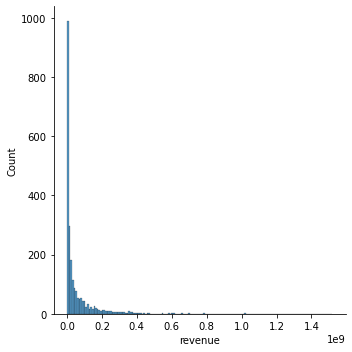

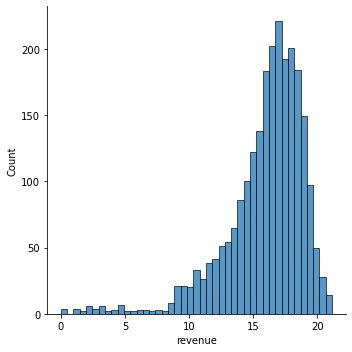

In [4]:
plot = sns.displot(y_train.revenue)
plot.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/revenue.pdf')
plot = sns.displot(np.log(y_train.revenue))
plot.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/logRevenue.pdf')

In [9]:
# inspecting if the data makes sense
suspect_count = 0
for i, revenue in enumerate(y_train['revenue']):
    if(revenue < 1000):
        suspect_count += 1
suspect_count

48

In [21]:
# save log-revenue as it is more normally distributed
x_train['logRevenue'] = y_train['revenue'].apply(lambda x: np.log(x))
dataset['logRevenue'] = dataset['revenue'].apply(lambda x: np.log(x))

### 2. Belongs to Collection

In [7]:
# inspect the format
for i, elem in enumerate(x_train['belongs_to_collection'][:5]):
    print(i, elem)

0 []
1 []
2 []
3 []
4 []


484


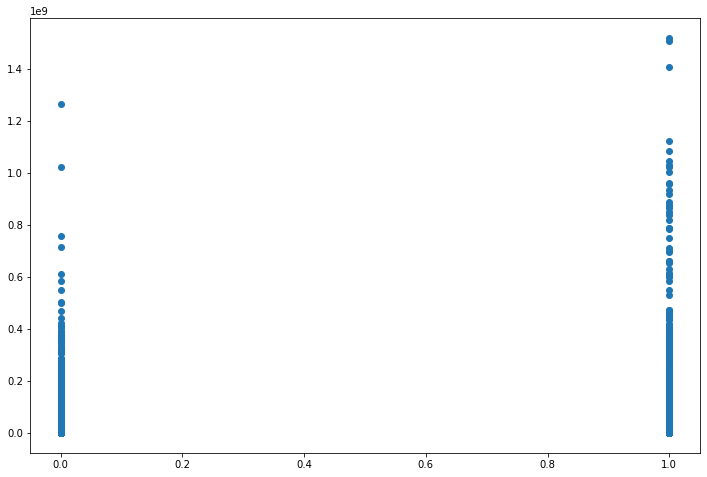

In [8]:
# transform to categorical variable
x_train['has_collection'] = x_train['belongs_to_collection'].apply(lambda x: 0 if (len(x) == 0) else 1)

#check amount of movies that are part of a collection
print(sum(x_train['has_collection']))

plt.figure(figsize=(12,8))
plt.scatter(x_train['has_collection'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/hasCollection.pdf')

In [22]:
# apply transformation to the whole dataset
dataset['has_collection'] = dataset['belongs_to_collection'].apply(lambda x: 0 if (len(x) == 0) else 1)
dataset = dataset.drop(['belongs_to_collection'], axis=1)

### 3. Budget

In [10]:
# inspecting the data
suspect_count = 0
for i, budget in enumerate(x_train['budget']):
    if budget <=1e5:
        suspect_count += 1
suspect_count

695

In [11]:
# creating a flag variable to mark suspect values of budget
x_train['isBudgetDirty'] = x_train['budget'].apply(lambda x : 1 if x < 1e5 else 0)

# inspect average budget
mean_budget =x_train[x_train['budget'] >= 1e5]['budget'].mean()
mean_budget

30854833.02696366

In [12]:
# replace dirty data with average budget
x_train.loc[x_train.budget < 1e5, 'budget'] = mean_budget

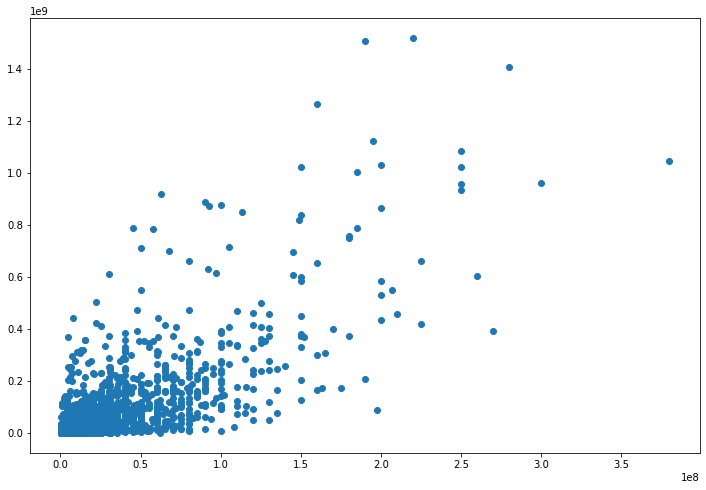

In [13]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['budget'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/budget.pdf')

In [23]:
# applying pre processing to the whole dataset
dataset['isBudgetDirty'] = dataset['budget'].apply(lambda x : 1 if x < 1e5 else 0)
mean_budget =dataset[dataset['budget'] >= 1e5]['budget'].mean()
dataset.loc[dataset.budget < 1e5, 'budget'] = mean_budget

### 4. Genres

In [15]:
# inspecting genres of the first few movies
for i, genres in enumerate(x_train['genres'][:5]):
    for gen in genres:
        print(gen['name'])

Comedy
Romance
Horror
Comedy
Music
Fantasy
Thriller
Action
Crime
Drama
Romance
Thriller
Comedy


In [11]:
# transform list of genres in a feature that counts the number of genres of a movie
x_train['list_of_genres'] = x_train['genres'].apply(lambda x: [gen['name'] for gen in x])
x_train['genre_count'] = x_train['list_of_genres'].apply(lambda x: len(x))
x_train = x_train.drop(['genres'], axis=1)
x_train = x_train.drop(['list_of_genres'], axis=1)

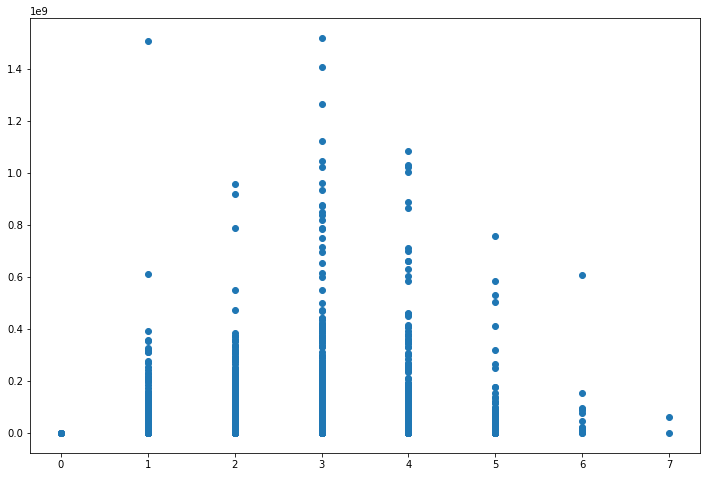

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['genre_count'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/genreCount.pdf')

In [24]:
# transform the whole dataset
dataset['list_of_genres'] = dataset['genres'].apply(lambda x: [gen['name'] for gen in x])
dataset['genre_count'] = dataset['list_of_genres'].apply(lambda x: len(x))
dataset = dataset.drop(['genres'], axis=1)
dataset = dataset.drop(['list_of_genres'], axis=1)

### 5. Homepage

In [19]:
# transforming feature to a binary variable
x_train['hasHomepage'] = x_train['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
x_train = x_train.drop(['homepage'], axis=1)

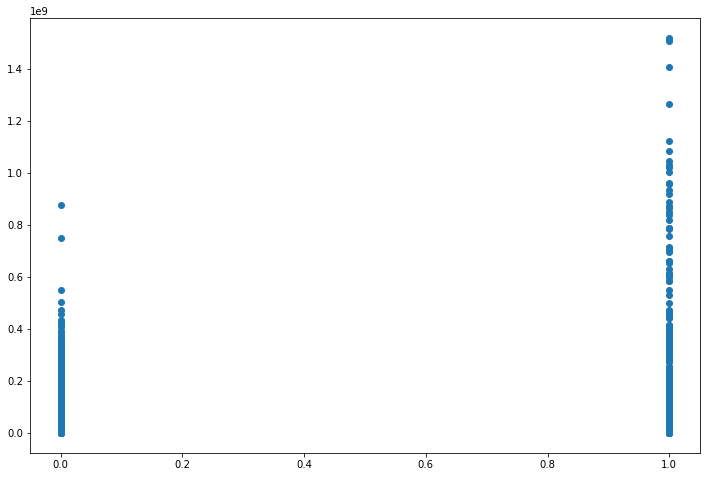

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['hasHomepage'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/hasHomepage.pdf')

In [25]:
# transforming the whole dataset
dataset['hasHomepage'] = dataset['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
dataset = dataset.drop(['homepage'], axis=1)

### 6. IMDB ID

In [26]:
# logically not relevant for the budget
dataset = dataset.drop(['imdb_id'], axis=1)

### 7. Original Language

In [33]:
# inspecting language distribution
list_of_languages = []
for lan in x_train['original_language']:
    list_of_languages.append(lan)
print(Counter(list_of_languages))
unique_languages = set(list_of_languages)
len(unique_languages)

Counter({'en': 2051, 'fr': 60, 'ru': 43, 'hi': 35, 'es': 33, 'ja': 29, 'it': 19, 'ko': 18, 'de': 17, 'cn': 16, 'zh': 16, 'ta': 15, 'sv': 6, 'nl': 5, 'pt': 5, 'ro': 4, 'da': 4, 'fa': 3, 'no': 2, 'te': 2, 'pl': 2, 'ml': 2, 'fi': 2, 'id': 1, 'hu': 1, 'el': 1, 'ur': 1, 'sr': 1, 'nb': 1, 'ar': 1, 'he': 1, 'bn': 1, 'mr': 1, 'vi': 1})


34

In [34]:
# transform into binary variable to identify english or not
x_train['is_english'] = x_train['original_language'].apply(lambda x: 1 if (x == 'en') else 0)
x_train = x_train.drop(['original_language'], axis=1)

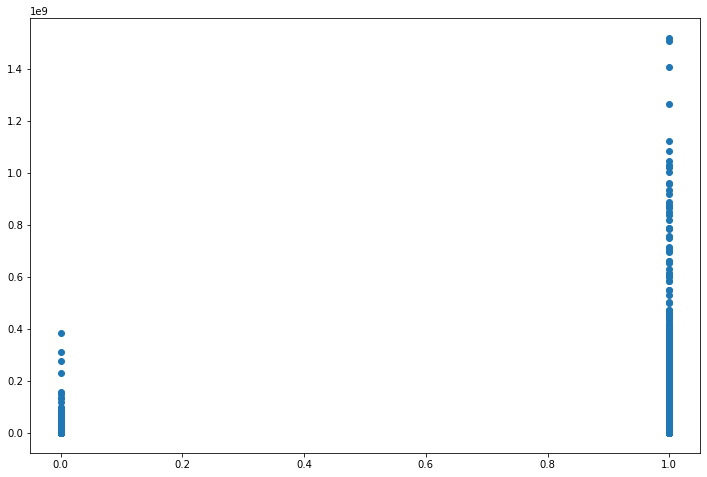

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['is_english'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/isEnglish.pdf')

In [27]:
# tranform whole dataset
dataset['is_english'] = dataset['original_language'].apply(lambda x: 1 if (x == 'en') else 0)
dataset = dataset.drop(['original_language'], axis=1)

### 8. Original title

In [28]:
# logically not useful for budget
dataset = dataset.drop(['original_title'], axis=1)

### 9. Overview

In [29]:
# logically not useful for budget
dataset = dataset.drop(['overview'], axis=1)

### 10. Popularity

In [29]:
# checking log pop for normality
x_train['logPop'] = x_train['popularity'].apply(lambda x: np.log(x)) #prova

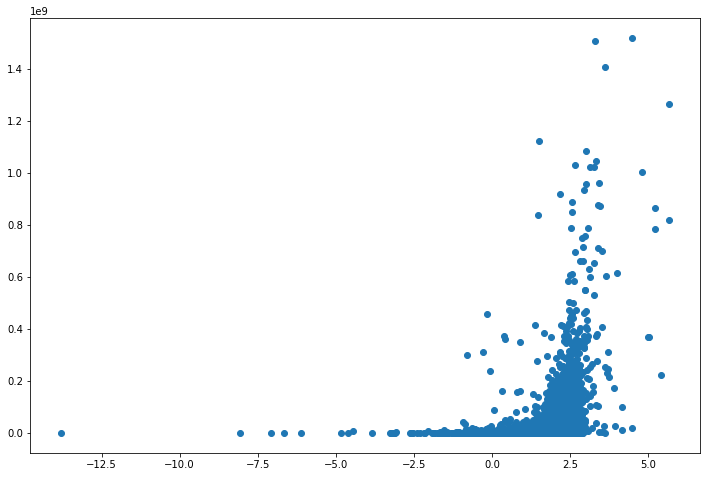

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['logPop'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/logPopularity.pdf')

In [31]:
# not looking good, keeping the normal scale
x_train = x_train.drop(['logPop'], axis=1)

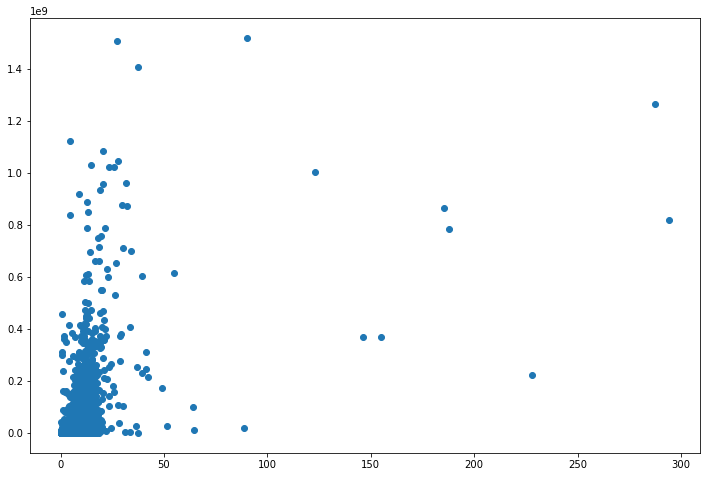

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['popularity'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/popularity.pdf')

### 11. Poster Path

In [30]:
# logically not useful for budget
dataset= dataset.drop(['poster_path'], axis=1)

### 12. Production Companies

In [ ]:
# inspecting the format
for i, e in enumerate(x_train['production_companies']):
    for comp in e:
        print(comp['name'])

In [12]:
# turning the values into a list of companies for each movie
x_train['list_of_companies'] = x_train['production_companies'].apply(lambda x: [comp['name'] for comp in x])

In [13]:
# extracting the most common companies
list_of_companies = []
for l in x_train['list_of_companies']:
    for comp in l:
        list_of_companies.append(comp)

print(len(list_of_companies))
unique_companies = set(list_of_companies)
print(len(unique_companies))
top_20_comp_pair = Counter(list_of_companies).most_common(20)
top_20_comp = []
for p in top_20_comp_pair:
    top_20_comp.append(p[0])
top_20_comp

6506
3183


['Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation',
 'Columbia Pictures',
 'Metro-Goldwyn-Mayer (MGM)',
 'New Line Cinema',
 'Touchstone Pictures',
 'Columbia Pictures Corporation',
 'Walt Disney Pictures',
 'TriStar Pictures',
 'Canal+',
 'Relativity Media',
 'United Artists',
 'Village Roadshow Pictures',
 'Miramax Films',
 'Regency Enterprises',
 'Dune Entertainment',
 'Fox Searchlight Pictures',
 'Lionsgate']

In [38]:
# number of companies for a movie may be informative
x_train['companies_count'] = x_train['list_of_companies'].apply(lambda x: len(x))

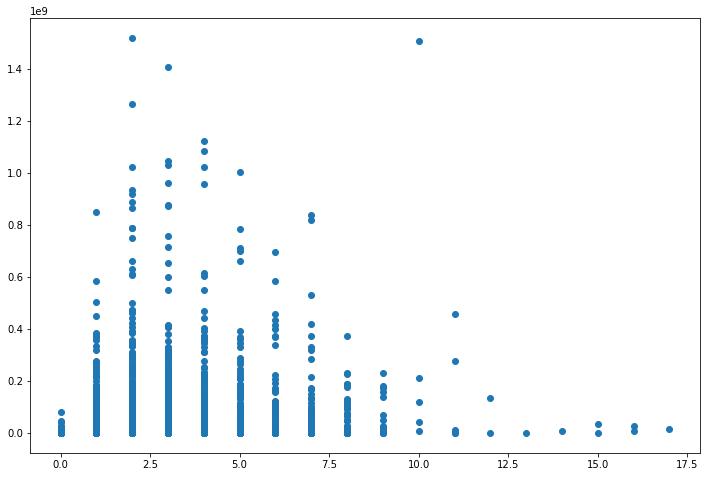

In [39]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['companies_count'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/companiesCount.pdf')

In [40]:
# creating a number of binary variables (one hot encoding) to check which of the top 20 company a movie was involved with
checked_companies = []
for i, l in enumerate(x_train['list_of_companies']):
    for comp in l:
        colName = 'is'+comp
        if(comp in top_20_comp and comp not in checked_companies):
            checked_companies.append(comp)
            x_train[colName] = pd.Series([1 if comp in x else 0 for x in x_train['list_of_companies']], index =x_train.index)


In [42]:
# dropping useless columns
x_train = x_train.drop(['production_companies'], axis=1)
x_train = x_train.drop(['list_of_companies'], axis=1)
x_train = x_train.drop(['companies_count'], axis=1)

isWarner Bros.


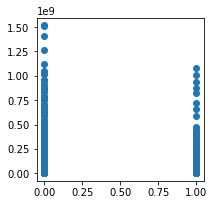

isUniversal Pictures


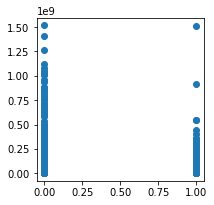

isParamount Pictures


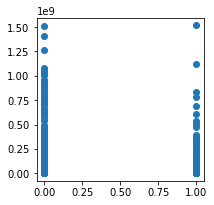

isTwentieth Century Fox Film Corporation


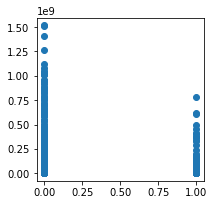

isColumbia Pictures


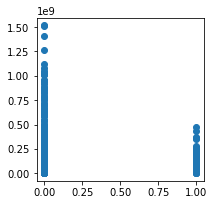

isMetro-Goldwyn-Mayer (MGM)


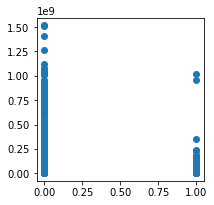

isNew Line Cinema


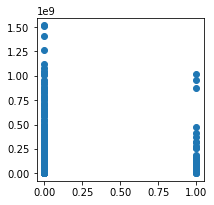

isTouchstone Pictures


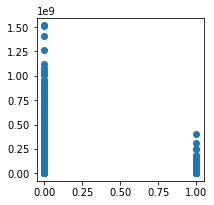

isColumbia Pictures Corporation


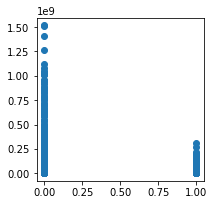

isWalt Disney Pictures


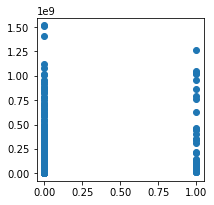

isTriStar Pictures


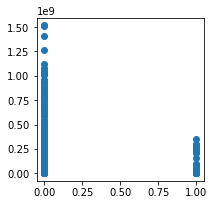

isCanal+


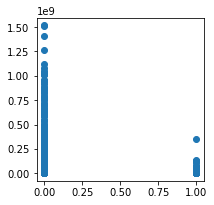

isRelativity Media


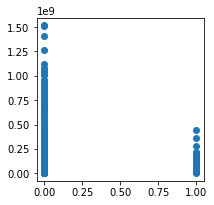

isUnited Artists


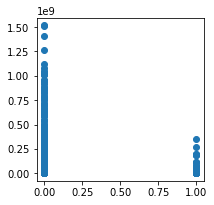

isVillage Roadshow Pictures


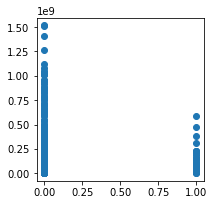

isMiramax Films


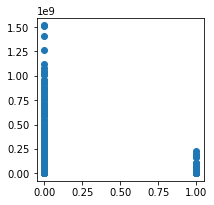

isRegency Enterprises


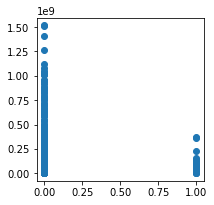

isDune Entertainment


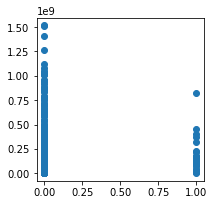

isFox Searchlight Pictures


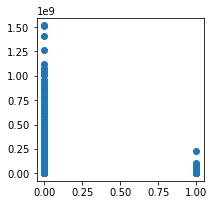

isLionsgate


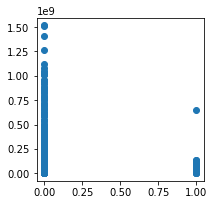

In [43]:
# checking plots for correlation
for comp in top_20_comp:
    col = 'is' + comp
    print(col)
    plt.figure(figsize=(3,3))
    plt.scatter(x_train[col], y_train['revenue'])
    plt.show()

In [31]:
# transforming the whole dataset
dataset['list_of_companies'] = dataset['production_companies'].apply(lambda x: [comp['name'] for comp in x])
list_of_companies = []
for l in dataset['list_of_companies']:
    for comp in l:
        list_of_companies.append(comp)
unique_companies = set(list_of_companies)
top_20_comp_pair = Counter(list_of_companies).most_common(20)
top_20_comp = []
for p in top_20_comp_pair:
    top_20_comp.append(p[0])

dataset['companies_count'] = dataset['list_of_companies'].apply(lambda x: len(x))
checked_companies = []
for i, l in enumerate(dataset['list_of_companies']):
    for comp in l:
        colName = 'is'+comp
        if(comp in top_20_comp and comp not in checked_companies):
            checked_companies.append(comp)
            dataset[colName] = pd.Series([1 if comp in x else 0 for x in dataset['list_of_companies']], index =dataset.index)
dataset = dataset.drop(['production_companies'], axis=1)
dataset = dataset.drop(['list_of_companies'], axis=1)
dataset = dataset.drop(['companies_count'], axis=1)

### 13. Production Countries

In [35]:
# checking if the isEnglish feature holds the same info
print(x_train[['production_countries', 'is_english']])

# dropping for redundancy
dataset = dataset.drop(['production_countries'], axis=1)

                                   production_countries  is_english
id                                                                 
643   [{'iso_3166_1': 'US', 'name': 'United States o...           1
701   [{'iso_3166_1': 'US', 'name': 'United States o...           1
227   [{'iso_3166_1': 'US', 'name': 'United States o...           1
1698  [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...           1
1011  [{'iso_3166_1': 'US', 'name': 'United States o...           1
...                                                 ...         ...
1639            [{'iso_3166_1': 'JP', 'name': 'Japan'}]           0
1096  [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...           1
1131  [{'iso_3166_1': 'US', 'name': 'United States o...           1
1295  [{'iso_3166_1': 'US', 'name': 'United States o...           1
861   [{'iso_3166_1': 'US', 'name': 'United States o...           1

[2400 rows x 2 columns]


### 14. Release Date

In [36]:
# building full 4 digits year
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 21:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

x_train['release_date'] = x_train['release_date'].apply(lambda x: fix_date(x))

x_train['release_date'] = x_train['release_date'].apply(lambda x: x.split('/'))

In [49]:
# separating d/m/y
x_train['release_day'] = pd.Series([x[1] for x in x_train['release_date']], index =x_train.index)
x_train['release_day'] = x_train['release_day'].astype(int)
x_train['release_month'] = pd.Series([x[0] for x in x_train['release_date']], index =x_train.index)
x_train['release_month'] = x_train['release_month'].astype(int)
x_train['release_year'] = pd.Series([x[2] for x in x_train['release_date']], index =x_train.index)
x_train['release_year'] = x_train['release_year'].astype(int)

# dropping the full date
x_train = x_train.drop(['release_date'], axis=1)

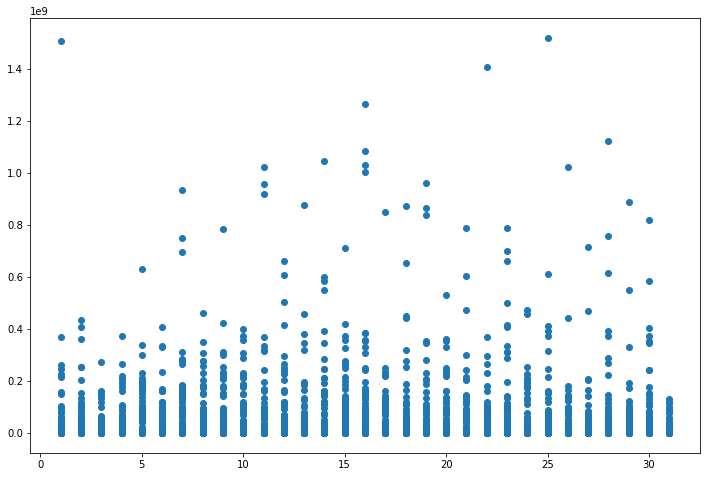

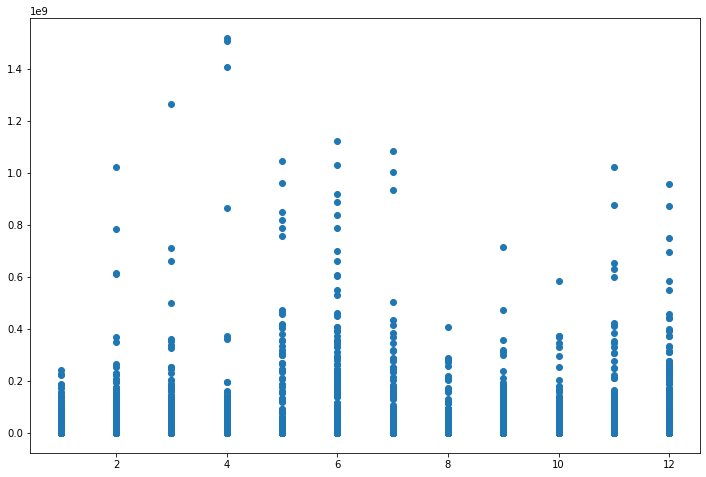

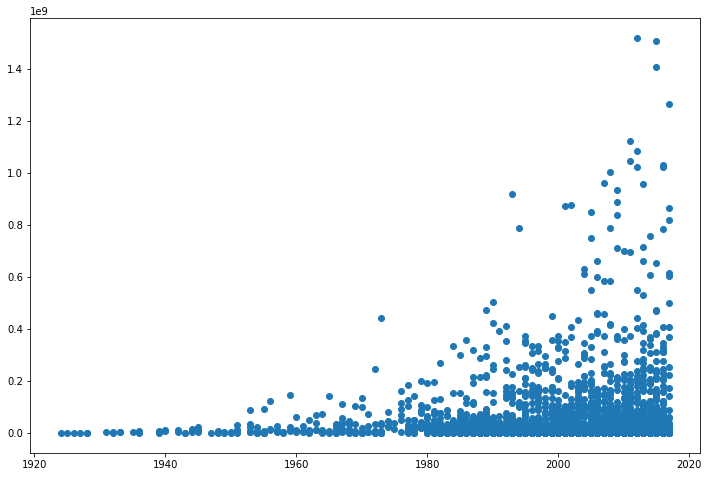

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['release_day'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/releaseDay.pdf')
plt.figure(figsize=(12,8))
plt.scatter(x_train['release_month'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/releaseMonth.pdf')
plt.figure(figsize=(12,8))
plt.scatter(x_train['release_year'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/releaseYear.pdf')

In [37]:
# transforming the whole dataset
dataset['release_date'] = dataset['release_date'].apply(lambda x: fix_date(x))
dataset['release_date'] = dataset['release_date'].apply(lambda x: x.split('/'))
dataset['release_day'] = pd.Series([x[1] for x in dataset['release_date']], index =dataset.index)
dataset['release_day'] = dataset['release_day'].astype(int)
dataset['release_month'] = pd.Series([x[0] for x in dataset['release_date']], index =dataset.index)
dataset['release_month'] = dataset['release_month'].astype(int)
dataset['release_year'] = pd.Series([x[2] for x in dataset['release_date']], index =dataset.index)
dataset['release_year'] = dataset['release_year'].astype(int)
dataset = dataset.drop(['release_date'], axis=1)

### 15. Runtime

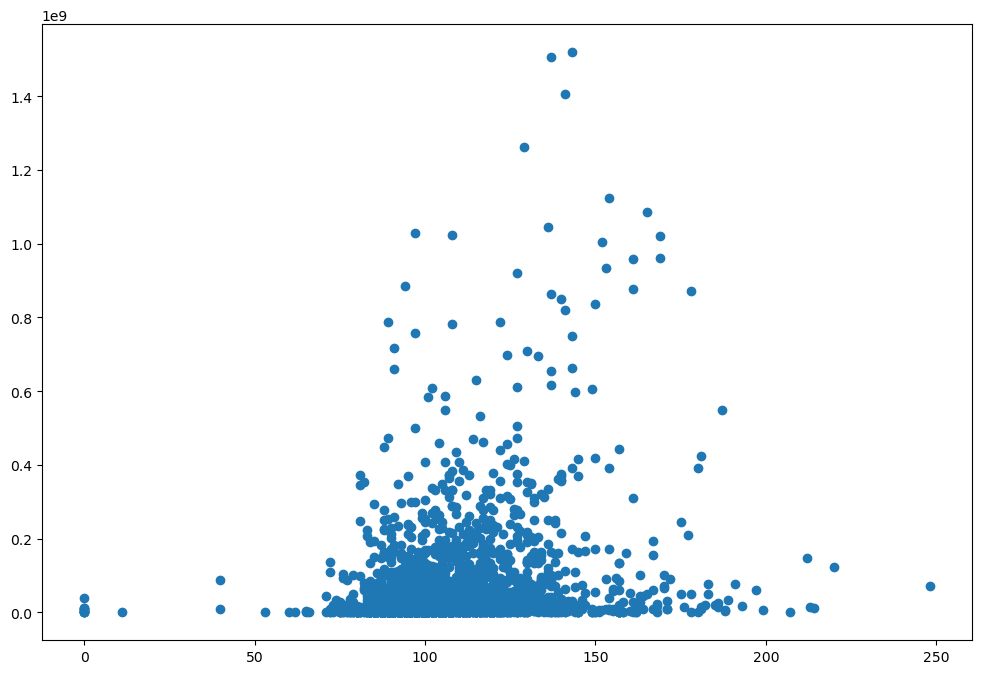

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['runtime'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/runtime.pdf')

In [6]:
# checking NAs
x_train[pd.isna(x_train['runtime'])]['original_title']

id
2303    Happy Weekend
1336          Королёв
Name: original_title, dtype: object

In [54]:
# substituing missing values with correct values from the internet
x_train.iloc[2302, x_train.columns.get_loc('runtime')] = 90
x_train.iloc[1335, x_train.columns.get_loc('runtime')] = 130

In [7]:
# checking if there are other NAs in the whole dataset
dataset[pd.isna(dataset['runtime'])]['original_title']

id
1336          Королёв
2303    Happy Weekend
Name: original_title, dtype: object

In [38]:
# fixing NAs again in the whole dataset
dataset.iloc[2302, dataset.columns.get_loc('runtime')] = 90
dataset.iloc[1335, dataset.columns.get_loc('runtime')] = 130

### 16. Spoken Language

In [39]:
# probably non informative, dropping
dataset = dataset.drop(['spoken_languages'], axis=1)

### 17. Status

In [8]:
# checking possible statuses
for i, status in enumerate(x_train['status']):
    if (status != 'Released'):
        print (i,status)

1171 Rumored
1427 Rumored


In [40]:
# few instances of not released, non informative
dataset = dataset.drop(['status'], axis=1)

### 18. Tagline

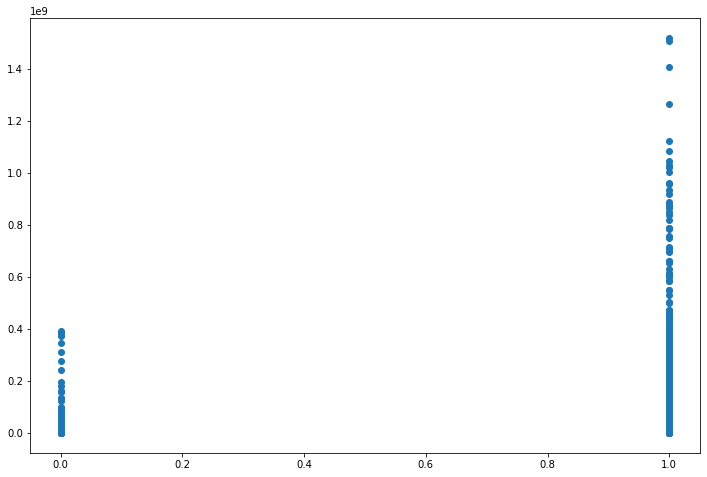

In [61]:
# tranrforming to binary variable
x_train['hasTagline'] = x_train['tagline'].apply(lambda x: 0 if pd.isna(x) else 1)
plt.figure(figsize=(12,8))
plt.scatter(x_train['hasTagline'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/hasTagline.pdf')

In [41]:
# transforming the whole dataset
dataset['hasTagline'] = dataset['tagline'].apply(lambda x: 0 if pd.isna(x) else 1)
dataset = dataset.drop(['tagline'], axis=1)

### 19. Title

In [42]:
# logically non informative, dropping
dataset = dataset.drop(['title'], axis=1)

### 20. Keywords

In [15]:
# inspecting data
for i, kws in enumerate(x_train['Keywords'][:2]):
    print (i)
    for keyword in kws:
        print(keyword['name'])

0
fast food restaurant
prince
heir to the throne
fish out of water
new york city
fake identity
duringcreditsstinger
searching for love
1
flower
solar eclipse
florist
assistant
plant
success
aggression by plant
investigation
nerd
blonde
carnivorous plant
remake
crush
based on play or musical
motorcycle
eclipse
part animated
dentist
bum
killer plant
skid row
based on movie
plant food
flesh eating plant
inept assistant
cult classic
man eating plant


C:\Users\bais_\AppData\Local\Temp\ipykernel_13640\399196397.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for i, kws in enumerate(x_train['Keywords'][:2]):


In [65]:
# transforming the data structure into list of strings
x_train['list_of_keywords'] = x_train['Keywords'].apply(lambda x: [comp['name'] for comp in x])

In [66]:
# creating a list of the 50 most common keywords
list_of_keywords = []
for l in x_train['list_of_keywords']:
    for key in l:
        list_of_keywords.append(key)

print(len(list_of_keywords))
unique_keywords = set(list_of_keywords)
print(len(unique_keywords))
top_50_keys_pair = Counter(list_of_keywords).most_common(50)
top_50_keys = []
for p in top_50_keys_pair:
    top_50_keys.append(p[0])
Counter(list_of_keywords).most_common(50)

17326
6488


[('woman director', 132),
 ('independent film', 120),
 ('duringcreditsstinger', 105),
 ('murder', 95),
 ('based on novel', 83),
 ('sport', 71),
 ('violence', 68),
 ('revenge', 65),
 ('dystopia', 64),
 ('friendship', 62),
 ('aftercreditsstinger', 57),
 ('sex', 57),
 ('biography', 57),
 ('love', 51),
 ('suspense', 51),
 ('sequel', 49),
 ('police', 49),
 ('drug', 46),
 ('teenager', 43),
 ('nudity', 43),
 ('female nudity', 41),
 ('high school', 40),
 ('prison', 40),
 ('los angeles', 38),
 ('musical', 37),
 ('family', 35),
 ('kidnapping', 34),
 ('father son relationship', 34),
 ('new york', 33),
 ('detective', 32),
 ('3d', 32),
 ('investigation', 31),
 ('based on comic', 31),
 ('london england', 30),
 ('paris', 29),
 ('corruption', 29),
 ('remake', 28),
 ('robbery', 28),
 ('wedding', 28),
 ('world war ii', 27),
 ('based on true story', 27),
 ('wife husband relationship', 27),
 ('suicide', 27),
 ('escape', 27),
 ('prostitute', 27),
 ('gay', 27),
 ('dying and death', 26),
 ('superhero', 26),


In [67]:
# creating a binary variable that checks whether the movie has at least one of the most common keywords
x_train['isInTop50Keywords'] = pd.Series([1 if list(set(x) & set(top_50_keys)) != [] else 0 for x in x_train['list_of_keywords']], index =x_train.index)

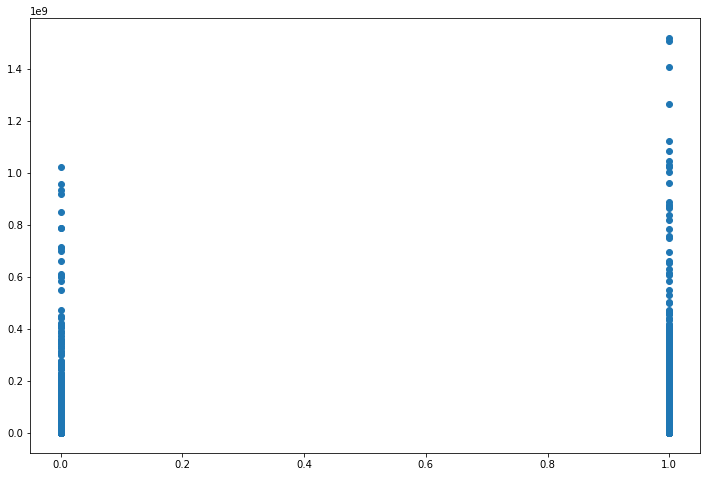

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['isInTop50Keywords'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/isInTop50Keywords.pdf')

In [69]:
# graph shows little correlation, dropping
x_train = x_train.drop(['isInTop50Keywords'], axis=1)

In [70]:
# trying to count the number of keywords of each movie
x_train['keywordsCount'] = x_train['list_of_keywords'].apply(lambda x: len(x))

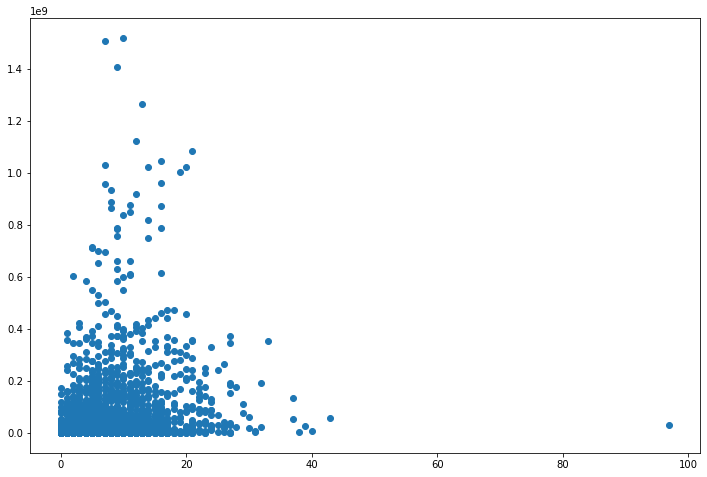

In [71]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['keywordsCount'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/keywordsCount.pdf')

In [72]:
# some correlation can be seen, let's keep it
# removing useless columns
x_train = x_train.drop(['Keywords'], axis=1)
x_train = x_train.drop(['list_of_keywords'], axis=1)

In [43]:
# transforming the whole dataset
dataset['list_of_keywords'] = dataset['Keywords'].apply(lambda x: [comp['name'] for comp in x])
dataset['keywordsCount'] = dataset['list_of_keywords'].apply(lambda x: len(x))
dataset = dataset.drop(['Keywords'], axis=1)
dataset = dataset.drop(['list_of_keywords'], axis=1)

### 21. Cast

In [ ]:
# inspecting data
for i, cast in enumerate(x_train['cast']):
    for actor in cast:
        print(actor['name'], actor['gender'])

In [17]:
# extracting actors name and making a list for each movie
x_train['list_of_cast'] = x_train['cast'].apply(lambda x: [act['name'] for act in x])

In [18]:
# checking if cast count is informative
x_train['castCount'] = x_train['list_of_cast'].apply(lambda x: len(x))

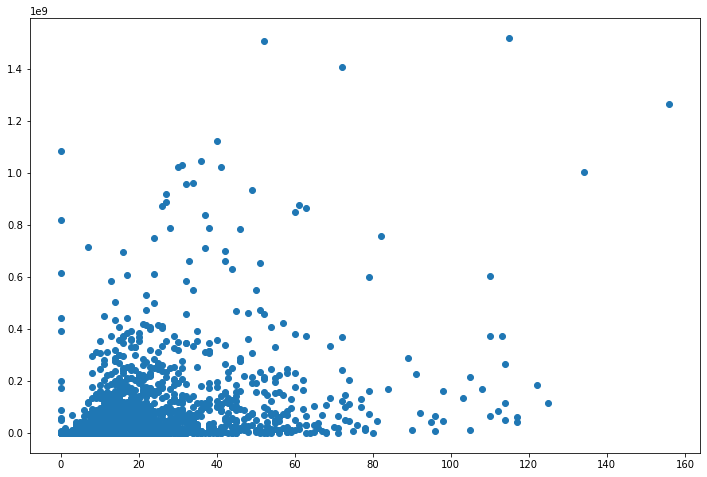

In [77]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['castCount'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/castCount.pdf')

In [19]:
# building a top 100 most common actors
list_of_actors = []
for l in x_train['list_of_cast']:
    for act in l:
        list_of_actors.append(act)

print(len(list_of_actors))
unique_actors = set(list_of_actors)
print(len(unique_actors))
top_100_actors_pair = Counter(list_of_actors).most_common(100)
top_100_actors = []
for p in top_100_actors_pair:
    top_100_actors.append(p[0])
Counter(list_of_actors).most_common(100)

49560
32697


[('Samuel L. Jackson', 25),
 ('Morgan Freeman', 24),
 ('Liam Neeson', 23),
 ('J.K. Simmons', 22),
 ('Robert De Niro', 22),
 ('Bruce Willis', 21),
 ('Bill Murray', 20),
 ('Forest Whitaker', 20),
 ('Willem Dafoe', 20),
 ('Jason Statham', 19),
 ('John Turturro', 19),
 ('Bruce McGill', 19),
 ('Susan Sarandon', 19),
 ('Ed Harris', 19),
 ('Robert Duvall', 18),
 ('Sylvester Stallone', 18),
 ('Denzel Washington', 17),
 ('Philip Seymour Hoffman', 17),
 ('Kevin Bacon', 17),
 ('Steve Buscemi', 17),
 ('Christopher Plummer', 17),
 ('Nicolas Cage', 16),
 ('Allison Janney', 16),
 ('Michael Caine', 16),
 ('Richard Jenkins', 16),
 ('John Goodman', 16),
 ('George Clooney', 16),
 ('Christopher Walken', 16),
 ('Dennis Quaid', 16),
 ('Mark Wahlberg', 15),
 ('Gene Hackman', 15),
 ('James Franco', 15),
 ('Ethan Hawke', 15),
 ('Brian Cox', 15),
 ('Jim Broadbent', 15),
 ('Christian Bale', 15),
 ('Matt Damon', 15),
 ('Colin Farrell', 15),
 ('Alec Baldwin', 15),
 ('Mel Gibson', 15),
 ('Ray Liotta', 15),
 ('Keith

In [20]:
# creating a feature that identifies the number of actors in the top 100 that were featured in the movie
x_train['countTop100Actors'] = pd.Series([len(list(set(x) & set(top_100_actors))) for x in x_train['list_of_cast']], index =x_train.index)

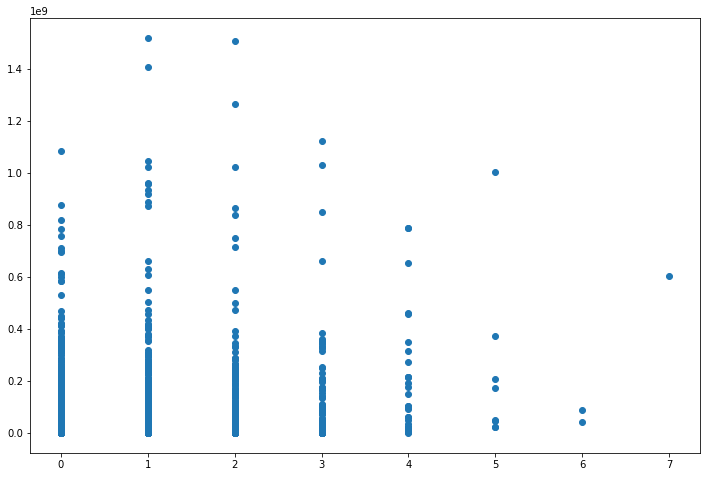

In [80]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['countTop100Actors'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/countTop100Actors.pdf')

In [81]:
# also creating one hot encoding for individual top 100 actor presence
checked_actors = []
for i, l in enumerate(x_train['list_of_cast']):
    for act in l:
        colName = 'is'+act
        if(act in top_100_actors and act not in checked_actors):
            checked_actors.append(act)
            x_train[colName] = pd.Series([1 if act in x else 0 for x in x_train['list_of_cast']], index =list(range(1,2401)))

In [44]:
# transforming the whole dataset
dataset['list_of_cast'] = dataset['cast'].apply(lambda x: [act['name'] for act in x])
dataset['castCount'] = dataset['list_of_cast'].apply(lambda x: len(x))
list_of_actors = []
for l in dataset['list_of_cast']:
    for act in l:
        list_of_actors.append(act)

unique_actors = set(list_of_actors)
top_100_actors_pair = Counter(list_of_actors).most_common(100)
top_100_actors = []
for p in top_100_actors_pair:
    top_100_actors.append(p[0])
Counter(list_of_actors).most_common(100)
dataset['countTop100Actors'] = pd.Series([len(list(set(x) & set(top_100_actors))) for x in dataset['list_of_cast']], index =dataset.index)

dataset = dataset.drop(['cast'], axis=1)
dataset = dataset.drop(['list_of_cast'], axis=1)

### 22. Crew

In [85]:
# extracting crew names
x_train['list_of_crew'] = x_train['crew'].apply(lambda x: [act['name'] for act in x])


In [86]:
# counting crew members
x_train['crew_count'] = x_train['list_of_crew'].apply(lambda x: len(x))

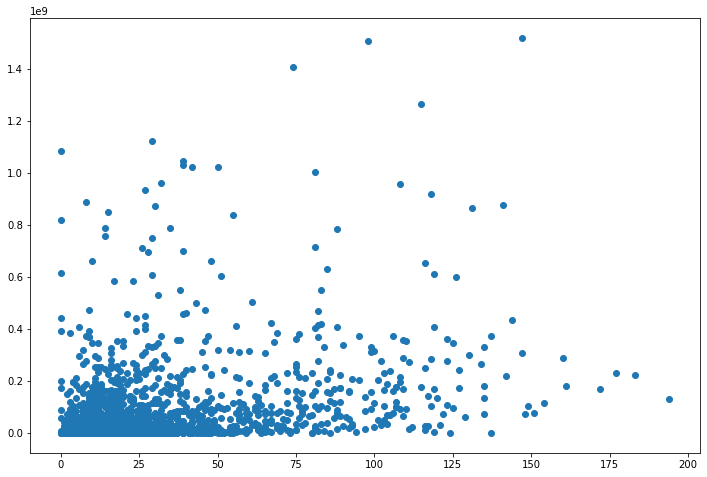

In [87]:
plt.figure(figsize=(12,8))
plt.scatter(x_train['crew_count'], y_train['revenue'])
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/crewCount.pdf')

In [45]:
# only keeping crew count, although correlation seems weak
dataset['list_of_crew'] = dataset['crew'].apply(lambda x: [act['name'] for act in x])
dataset['crew_count'] = dataset['list_of_crew'].apply(lambda x: len(x))
dataset = dataset.drop(['list_of_crew'], axis=1)
dataset = dataset.drop(['crew'], axis=1)

In [46]:
# rearranging order of column for practical reasons
dataset['Revenue'] = dataset['revenue']
dataset['LogRevenue'] = dataset['logRevenue']
dataset = dataset.drop(['revenue'], axis=1)
dataset = dataset.drop(['logRevenue'], axis=1)

In [90]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 38 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   budget                                    3000 non-null   float64
 1   popularity                                3000 non-null   float64
 2   runtime                                   3000 non-null   float64
 3   has_collection                            3000 non-null   int64  
 4   isBudgetDirty                             3000 non-null   int64  
 5   genre_count                               3000 non-null   int64  
 6   hasHomepage                               3000 non-null   int64  
 7   is_english                                3000 non-null   int64  
 8   isParamount Pictures                      3000 non-null   int64  
 9   isUnited Artists                          3000 non-null   int64  
 10  isMetro-Goldwyn-Mayer (MGM)         

# Machine Learning Models

## 1. BASELINE - Linear regression: Budget + Popularity

In [47]:
# extracting budget and popularity features
dataset_mat = dataset.astype(float).values
x = dataset_mat[:, :2]
y = dataset_mat[:,36]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [48]:
# creating the model
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
print ("Intercept: ", model.intercept_)
print ("Coefficients [slopes]:", model.coef_)
print ()
print ("Train Error : {:.3f}".format( mean_squared_error(y_true = y_train,  
                                          y_pred = y_pred_train)) )
print ("Test Error : {:.3f}".format( mean_squared_error(y_true = y_test,  
                                          y_pred = y_pred_test)) )
print(f"R^2 score: {model.score(x_test, y_test)}")

Intercept:  -41196973.74542247
Coefficients [slopes]: [2.59889525e+00 3.16315113e+06]

Train Error : 8411883287163542.000
Test Error : 7282202697059580.000
R^2 score: 0.5479176051438146


In [49]:
# Retraining it as a 1 dimensional model (PCA), useful for visualizing
pca = PCA(n_components=1)
x = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
print ("Intercept: ", model.intercept_)
print ("Coefficients [slopes]:", model.coef_)
print ()
print ("Train Error : {:.3f}".format( mean_squared_error(y_true = y_train,  
                                          y_pred = y_pred_train)) )
print ("Test Error : {:.3f}".format( mean_squared_error(y_true = y_test,  
                                          y_pred = y_pred_test)) )
print(f"R^2 score: {model.score(x_test, y_test)}")

Intercept:  67131902.38890475
Coefficients [slopes]: [2.94098569]

Train Error : 9763078678897512.000
Test Error : 8435797985416258.000
R^2 score: 0.47630189457513206


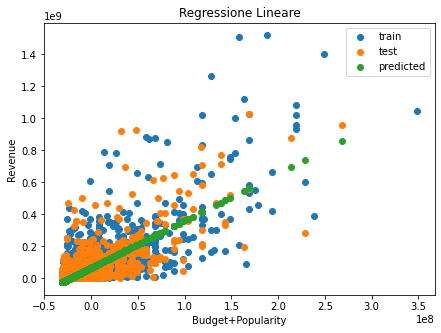

In [95]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_train, y_train, label='train')
ax.scatter(x_test, y_test, label='test')
ax.scatter(x_test, y_pred_test, label='predicted')
ax.set_title("Regressione Lineare")
ax.set_xlabel("Budget+Popularity")
ax.set_ylabel("Revenue")
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/baseline.pdf')

## 2. K-Nearest-Neighbors

In [50]:
# extracting all features
x = dataset_mat[:,:36]
y = dataset_mat[:,36]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [51]:
# training with 10 neighbors
kNN = neighbors.KNeighborsRegressor(n_neighbors=10)
kNN.fit(x_train,y_train)

y_pred = kNN.predict(x_test)

# compute performance metrics
train_acc = mean_squared_error(y_true=y_train, y_pred=kNN.predict(x_train))
test_acc = mean_squared_error(y_true=y_test, y_pred=kNN.predict(x_test))
print(f"Train MSE: {train_acc}")
print(f"Test MSE: {test_acc}")
print (f"Test Accuracy: {kNN.score(x_test, y_test)}")

Train MSE: 7320826415310310.0
Test MSE: 7878571462315999.0
Test Accuracy: 0.5108947659246577


In [61]:
# trying out a scaler
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
scaler = MinMaxScaler()
scaler.fit(x_train)

kNN = neighbors.KNeighborsRegressor(n_neighbors=10)
kNN.fit(scaler.transform(x_train),y_train)

y_pred = kNN.predict(scaler.transform(x_test))

# compute Accuracy
train_acc = mean_squared_error(y_true=y_train, y_pred=kNN.predict(scaler.transform(x_train)))
test_acc = mean_squared_error(y_true=y_test, y_pred=kNN.predict(scaler.transform(x_test)))
print(f"Train MSE: {train_acc}")
print(f"Test MSE: {test_acc}")
print (f"Test Accuracy: {kNN.score(scaler.transform(x_test), y_test)}")

Train MSE: 8073759034037975.0
Test MSE: 8633615223246821.0
Test Accuracy: 0.4867022190538618


### Finding the best k - Validation

[6783819743951744.0, 12]
[0.6218914087145395, 12]
8053801958854475.0


0.5211740890967109

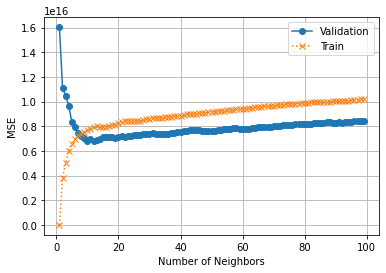

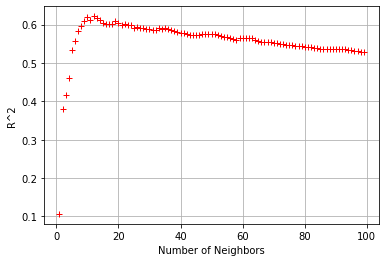

In [100]:
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_80, y_train_80, test_size=0.25, random_state=42)
train_mse=[]
valid_mse= []
R_square = []

#tuning
for k in range(1,100):
    kNN = neighbors.KNeighborsRegressor(n_neighbors=k)
    kNN.fit(x_train,y_train)

    y_pred = kNN.predict(x_valid)

#Accuracy
    train_acc = mean_squared_error(y_true=y_train, y_pred=kNN.predict(x_train))
    valid_acc = mean_squared_error(y_true=y_valid, y_pred=kNN.predict(x_valid))
    train_mse.append([train_acc, k])
    valid_mse.append([valid_acc, k])
    R_square.append([kNN.score(x_valid, y_valid), k])
print(min(valid_mse))
print(max(R_square))

train_mse = np.array(train_mse)
valid_mse = np.array(valid_mse)
R_square = np.array(R_square)

#grafici
fig, ax = plt.subplots()
ax.plot(valid_mse[:,1], valid_mse[:,0], "o-", label="Validation")
ax.plot(train_mse[:,1], train_mse[:,0], "x:", label="Train")

ax.set_ylabel("MSE")
ax.set_xlabel("Number of Neighbors")
ax.grid()
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/validationKNN.pdf')

fig, ax = plt.subplots()
ax.plot(R_square[:,1], R_square[:,0], "r+", label="R^2")
ax.set_ylabel("R^2")
ax.set_xlabel("Number of Neighbors")
ax.grid()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/validationKnnRsquared.pdf')

#ricerca del k migliore
min_mse = float('inf')
best_k = 0
for mse, k in valid_mse:
    if(min_mse > mse):
        best_k = k
        min_mse = mse
        
kNN = neighbors.KNeighborsRegressor(n_neighbors=int(best_k))
kNN.fit(x_train_80,y_train_80)
y_pred = kNN.predict(x_test)
test_acc = mean_squared_error(y_true=y_test, y_pred=kNN.predict(x_test))
print(test_acc)
kNN.score(x_test, y_test)

### Finding the best k - 5 folds cross validation

[0.5684228187531195, 23]
7289502717567317.0


0.5666142777531586

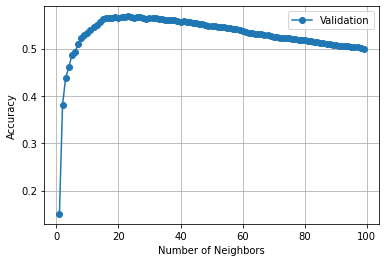

In [101]:
# finding the best k - 5 folds cross-validation
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
train_mse=[]
valid_acc= []
R_square = []
#tuning
for k in range(1,100):
    kNN = neighbors.KNeighborsRegressor(n_neighbors=k)

    scores = cross_val_score(kNN, x_train_80, y_train_80, 
                         cv=5, 
                         verbose = 0)
    #accuracy
    valid_acc_score = scores.mean()
    valid_acc.append([valid_acc_score, k])
print(max(valid_acc))

valid_acc = np.array(valid_acc)

#grafici
fig, ax = plt.subplots()
ax.plot(valid_acc[:,1], valid_acc[:,0], "o-", label="Validation")

ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of Neighbors")
ax.grid()
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/crossValidationKNN.pdf')

#ricerca del k migliore
max_acc = 0
best_k = 0
for acc, k in valid_acc:
    if(max_acc < acc):
        best_k = k
        max_acc = acc
        
kNN = neighbors.KNeighborsRegressor(n_neighbors=int(best_k))
kNN.fit(x_train_80,y_train_80)
y_pred = kNN.predict(x_test)
test_acc = mean_squared_error(y_true=y_test, y_pred=kNN.predict(x_test))
print(test_acc)
kNN.score(x_test, y_test)

## 3. Linear Regression

In [57]:
# Trying linear regression again, using all features and a scaler
x = dataset_mat[:, :36]
y = dataset_mat[:,36]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
scaler = MinMaxScaler()
scaler.fit(x_train)
model = LinearRegression(fit_intercept=True)
model.fit(scaler.transform(x_train), y_train)
y_pred_test = model.predict(scaler.transform(x_test))
y_pred_train = model.predict(scaler.transform(x_train))
print ("Intercept: ", model.intercept_)
print ("Coefficients [slopes]:", model.coef_)
print ()
print ("Train Error : {:.3f}".format( mean_squared_error(y_true = y_train,  
                                          y_pred = y_pred_train)) )
print ("Test Error : {:.3f}".format( mean_squared_error(y_true = y_test,  
                                          y_pred = y_pred_test)) )
print(f"R^2 test score: {model.score(scaler.transform(x_test), y_test)}")

Intercept:  -35997109.6406844
Coefficients [slopes]: [ 9.14100837e+08  5.97986132e+08  5.67449312e+07  5.37257223e+07
 -5.36543648e+07 -1.96678541e+07  2.25740769e+07 -1.01617878e+06
  2.31823372e+07  2.00172325e+06 -1.39088697e+07  6.02219542e+07
 -5.86256834e+06 -1.61869278e+07 -8.93349591e+06  2.83483121e+07
  3.78956141e+06 -6.12535102e+06  6.40776431e+05  1.32409955e+07
 -1.25035764e+07  3.18990647e+06 -1.54039894e+07 -1.82375332e+07
 -2.93814065e+07 -2.37184598e+07 -2.02379347e+07  2.10070339e+07
  8.92802338e+06  3.17829065e+06 -3.35357038e+07 -5.86828873e+06
  6.00272088e+07  7.94154702e+07  8.60048774e+06  1.12271100e+06]

Train Error : 6544202111734663.000
Test Error : 5992790750349118.000
R^2 test score: 0.6437082132701382


### Features Importance

<BarContainer object of 36 artists>

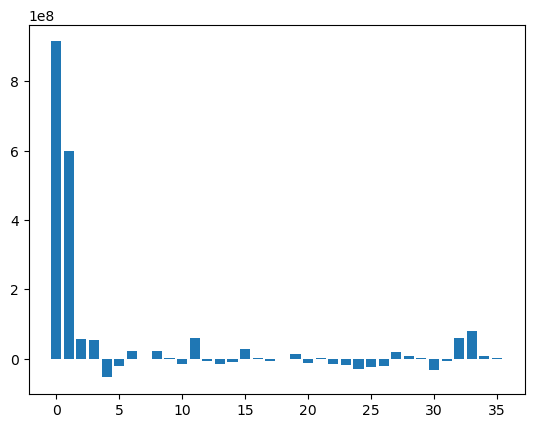

In [60]:
importance = model.coef_

plt.bar([x for x in range(len(importance))], importance)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/linearRegressorImportance.pdf')

## 4. Decision Tree

In [63]:
# training a DT with 10 max leaves
x = dataset_mat[:, :36]
y = dataset_mat[:,36]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
dt = tree.DecisionTreeRegressor(max_leaf_nodes=10)
dt.fit(x_train,y_train)
train_acc = mean_squared_error(y_true=y_train, y_pred=dt.predict(x_train))
test_acc = mean_squared_error(y_true=y_test, y_pred=dt.predict(x_test))
print(f"Train MSE: {train_acc}")
print(f"Test MSE: {test_acc}")
print (f"Test Accuracy: {dt.score(x_test, y_test)}")

Train MSE: 6036410932602866.0
Test MSE: 9912567606418978.0
Test Accuracy: 0.41066415119436306


### Finding best #leaves - Validation

[8580436808744559.0, 36]
[0.5217536731778768, 36]
1.0339782324878286e+16


0.385264783571141

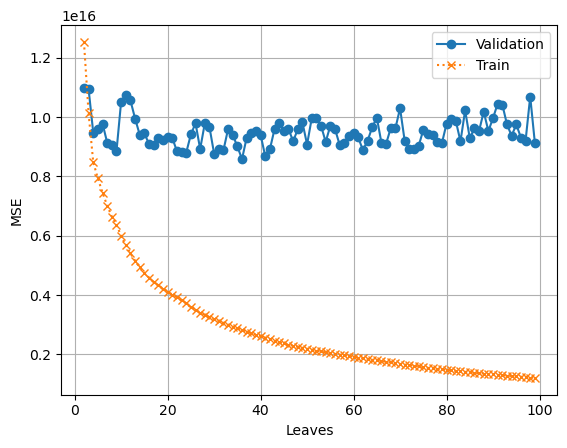

In [75]:
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_80, y_train_80, test_size=0.25, random_state=42)
train_mse=[]
valid_mse= []
R_square = []
#tuning
for k in range(2,100):
    dt = tree.DecisionTreeRegressor(max_leaf_nodes=k)
    dt.fit(x_train,y_train)

    y_pred = dt.predict(x_valid)

#Accuracy
    train_acc = mean_squared_error(y_true=y_train, y_pred=dt.predict(x_train))
    valid_acc = mean_squared_error(y_true=y_valid, y_pred=dt.predict(x_valid))
    train_mse.append([train_acc, k])
    valid_mse.append([valid_acc, k])
    R_square.append([dt.score(x_valid, y_valid), k])
print(min(valid_mse))
print(max(R_square))

train_mse = np.array(train_mse)
valid_mse = np.array(valid_mse)
R_square = np.array(R_square)

#grafici
fig, ax = plt.subplots()
ax.plot(valid_mse[:,1], valid_mse[:,0], "o-", label="Validation")
ax.plot(train_mse[:,1], train_mse[:,0], "x:", label="Train")

ax.set_ylabel("MSE")
ax.set_xlabel("Leaves")
ax.grid()
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/validationTree.pdf')

#ricerca del k migliore
min_mse = float('inf')
best_k = 0
for mse, k in valid_mse:
    if(min_mse > mse):
        best_k = k
        min_mse = mse
        
dt = tree.DecisionTreeRegressor(max_leaf_nodes=int(best_k))
dt.fit(x_train_80,y_train_80)
y_pred = dt.predict(x_test)
test_acc = mean_squared_error(y_true=y_test, y_pred=dt.predict(x_test))
print(test_acc)
dt.score(x_test, y_test)

### Features Importance

<BarContainer object of 36 artists>

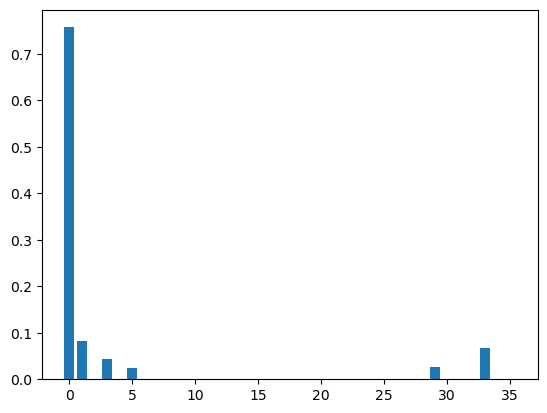

In [64]:
importance = dt.feature_importances_
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/validationTreeImportance.pdf')

In [76]:
# trying to remove unimportant features
accuraces = []
for min_imp in np.arange(0, 0.5, 0.01):
    sel_features = []
    for i, x in enumerate(importance):
        if(x >min_imp):
            sel_features.append(i)

    x = dataset_mat[:,sel_features]
    y = dataset_mat[:,36]
    x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train_80, y_train_80, test_size=0.25, random_state=42)
    dt = tree.DecisionTreeRegressor(max_leaf_nodes=int(best_k))
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_valid)
    test_acc = mean_squared_error(y_true=y_valid, y_pred=dt.predict(x_valid))
    accuraces.append((dt.score(x_valid, y_valid), sel_features))
    
best_features = max(accuraces)[1]
x = dataset_mat[:,best_features]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
dt = tree.DecisionTreeRegressor(max_leaf_nodes=int(best_k))
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
test_acc = mean_squared_error(y_true=y_test, y_pred=dt.predict(x_test))
print(f"Test MSE: {test_acc}, Test Accuracy: {dt.score(x_test, y_test)}")

Test MSE: 9132108066088724.0, Test Accuracy: 0.4570651245769951


### Finding the best #leaves - 5 folds cross validation

[0.5468594085751853, 5]
8009607089528607.0
0.5238016243490453


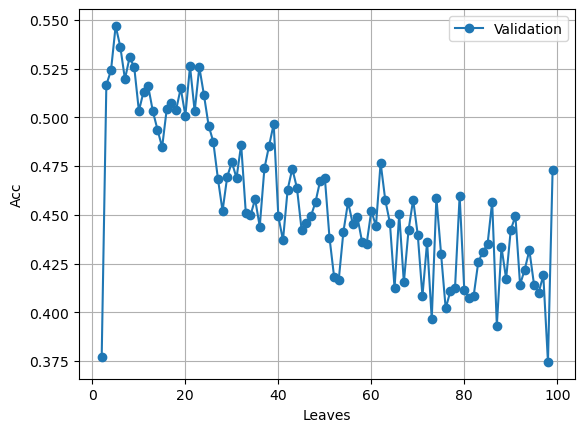

In [78]:
#cross-validation
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
train_mse=[]
valid_acc= []
R_square = []
#tuning
for k in range(2,100):
    dt = tree.DecisionTreeRegressor(max_leaf_nodes=k)
    scores = cross_val_score(dt, x_train_80, y_train_80, 
                         cv=5, 
                         verbose = 0)
    #Accuracy
    valid_acc_score = scores.mean()
    valid_acc.append([valid_acc_score, k])
print(max(valid_acc))
valid_acc = np.array(valid_acc)

#grafici
fig, ax = plt.subplots()
ax.plot(valid_acc[:,1], valid_acc[:,0], "o-", label="Validation")

ax.set_ylabel("Acc")
ax.set_xlabel("Leaves")
ax.grid()
ax.legend()
#plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/crossValidationTree.pdf')

#ricerca del k migliore
max_acc = 0
best_k = 0
for acc, k in valid_acc:
    if(max_acc < acc):
        best_k = k
        max_acc = acc
        
dt = tree.DecisionTreeRegressor(max_leaf_nodes=int(best_k))
dt.fit(x_train_80,y_train_80)
y_pred = dt.predict(x_test)
test_acc = mean_squared_error(y_true=y_test, y_pred=dt.predict(x_test))
print(test_acc)
print(dt.score(x_test, y_test))

### Features Importance - cross validated #leaves

<BarContainer object of 36 artists>

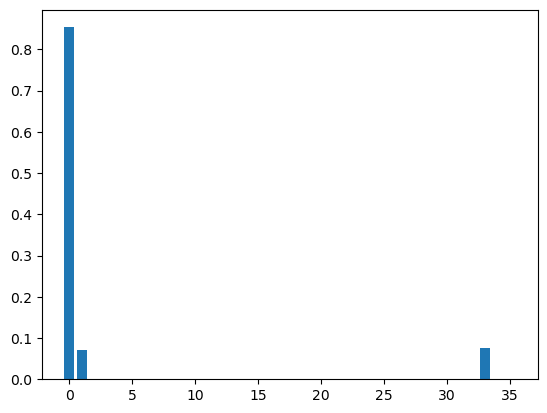

In [79]:
importance = dt.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/crossValidationTreeImportance.pdf')

In [110]:
# removing unimportant features
accuraces = []
for min_imp in np.arange(0, 0.1, 0.01):
    sel_features = []
    for i, x in enumerate(importance):
        if(x >min_imp):
            sel_features.append(i)

    x = dataset_mat[:,sel_features]
    y = dataset_mat[:,36]
    x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    dt = tree.DecisionTreeRegressor(max_leaf_nodes=int(best_k))
    scores = cross_val_score(dt, x_train_80, y_train_80, 
                             cv=5, 
                             verbose = 0)
    valid_acc_score = scores.mean()
    accuraces.append((valid_acc_score, sel_features))
    
best_features = max(accuraces)[1]
x = dataset_mat[:,best_features]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
dt = tree.DecisionTreeRegressor(max_leaf_nodes=int(best_k))
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
test_acc = mean_squared_error(y_true=y_test, y_pred=dt.predict(x_test))
print(test_acc, dt.score(x_test, y_test))

8009607089528607.0 0.5238016243490453


## 5. Random Forest

In [111]:
# Training a RF with 50 trees
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
rf = RandomForestRegressor(n_estimators=50)
rf.fit(x_train,y_train)
train_acc = mean_squared_error(y_true=y_train, y_pred=rf.predict(x_train))
test_acc = mean_squared_error(y_true=y_test, y_pred=rf.predict(x_test))
acc = rf.score(x_test,y_test)
print(train_acc)
print(test_acc)
acc

921418326286592.8
5131749664766862.0


0.6949000335104911

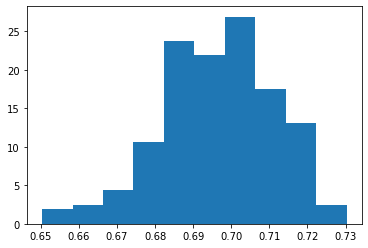

In [112]:
# checking accuracy dsitribution
hist_data = []
for i in range (0,200):
    rf = RandomForestRegressor(n_estimators=50)
    rf.fit(x_train,y_train)
    hist_data.append(rf.score(x_test,y_test))
plt.hist(hist_data, density = True)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestBaseHist.pdf')

### Finding the best # trees - Validation

[5611059593882638.0, 47]
[0.6872573389714136, 47]
5165397037354329.0


0.6928995828027378

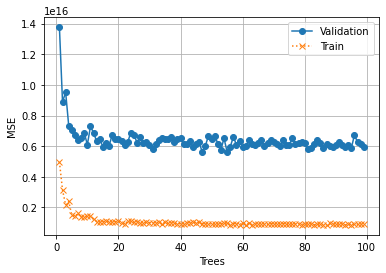

In [120]:
#validation
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_80, y_train_80, test_size=0.25, random_state=42)
train_mse=[]
valid_mse= []
R_square = []
#tuning
for k in range(1,100):
    rf = RandomForestRegressor(n_estimators=k)
    rf.fit(x_train,y_train)
#Accuracy
    train_acc = mean_squared_error(y_true=y_train, y_pred=rf.predict(x_train))
    valid_acc = mean_squared_error(y_true=y_valid, y_pred=rf.predict(x_valid))
    train_mse.append([train_acc, k])
    valid_mse.append([valid_acc, k])
    R_square.append([rf.score(x_valid, y_valid), k])
print(min(valid_mse))
print(max(R_square))

train_mse = np.array(train_mse)
valid_mse = np.array(valid_mse)
R_square = np.array(R_square)

#grafici
fig, ax = plt.subplots()
ax.plot(valid_mse[:,1], valid_mse[:,0], "o-", label="Validation")
ax.plot(train_mse[:,1], train_mse[:,0], "x:", label="Train")

ax.set_ylabel("MSE")
ax.set_xlabel("Trees")
ax.grid()
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestValidation.pdf')

#ricerca del k migliore
min_mse = float('inf')
best_k = 0
for mse, k in valid_mse:
    if(min_mse > mse):
        best_k = k
        min_mse = mse
        
rf = RandomForestRegressor(n_estimators=int(best_k))
rf.fit(x_train_80,y_train_80)
test_acc = mean_squared_error(y_true=y_test, y_pred=rf.predict(x_test))
print(test_acc)
rf.score(x_test, y_test)

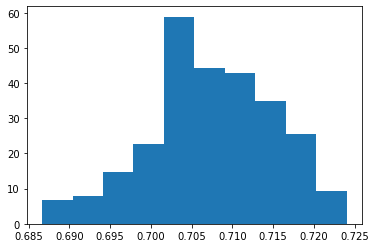

In [114]:
hist_data = []
for i in range (0,200):
    rf = RandomForestRegressor(n_estimators=int(best_k))
    rf.fit(x_train,y_train)
    hist_data.append(rf.score(x_test,y_test))
plt.hist(hist_data, density = True)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestValidationHist.pdf')

### Features Importance

Feature: 0, Score: 0.55457
Feature: 1, Score: 0.12052
Feature: 2, Score: 0.05026
Feature: 3, Score: 0.03611
Feature: 4, Score: 0.00200
Feature: 5, Score: 0.01453
Feature: 6, Score: 0.00627
Feature: 7, Score: 0.00039
Feature: 8, Score: 0.00379
Feature: 9, Score: 0.00088
Feature: 10, Score: 0.00038
Feature: 11, Score: 0.00304
Feature: 12, Score: 0.00237
Feature: 13, Score: 0.00002
Feature: 14, Score: 0.00028
Feature: 15, Score: 0.00096
Feature: 16, Score: 0.00295
Feature: 17, Score: 0.00237
Feature: 18, Score: 0.00051
Feature: 19, Score: 0.00121
Feature: 20, Score: 0.00084
Feature: 21, Score: 0.00197
Feature: 22, Score: 0.00086
Feature: 23, Score: 0.00026
Feature: 24, Score: 0.00044
Feature: 25, Score: 0.00050
Feature: 26, Score: 0.00032
Feature: 27, Score: 0.00156
Feature: 28, Score: 0.01983
Feature: 29, Score: 0.03696
Feature: 30, Score: 0.02632
Feature: 31, Score: 0.00089
Feature: 32, Score: 0.01991
Feature: 33, Score: 0.04218
Feature: 34, Score: 0.00821
Feature: 35, Score: 0.03553


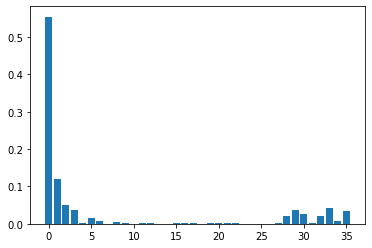

In [121]:
importance = rf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestValidationImportance.pdf')

### Finding the best # trees - 5 folds cross validation

[0.6781278135665703, 143]
5071205075799637.0
0.6984996151876423


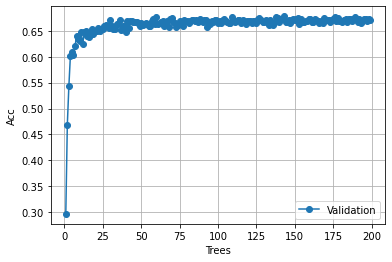

In [124]:
#cross-validation
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
train_mse=[]
valid_acc= []
R_square = []
#tuning
for k in range(1,200):
    rf = RandomForestRegressor(n_estimators=k)
    scores = cross_val_score(rf, x_train_80, y_train_80, 
                         cv=5, 
                         verbose = 0)
    #Accuracy
    valid_acc_score = scores.mean()
    valid_acc.append([valid_acc_score, k])
print(max(valid_acc))
valid_acc = np.array(valid_acc)

#grafici
fig, ax = plt.subplots()
ax.plot(valid_acc[:,1], valid_acc[:,0], "o-", label="Validation")

ax.set_ylabel("Acc")
ax.set_xlabel("Trees")
ax.grid()
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestCrossValidation.pdf')

#ricerca del k migliore
max_acc = 0
best_k = 0
for acc, k in valid_acc:
    if(max_acc < acc):
        best_k = k
        max_acc = acc
        
rf = RandomForestRegressor(n_estimators=int(best_k))
rf.fit(x_train_80,y_train_80)
test_acc = mean_squared_error(y_true=y_test, y_pred=rf.predict(x_test))
print(test_acc)
print(rf.score(x_test, y_test))

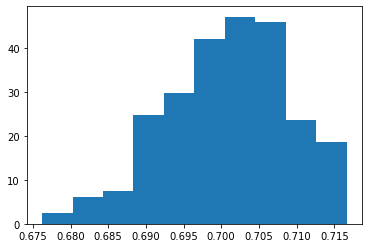

In [125]:
hist_data = []
for i in range (0,200):
    rf = RandomForestRegressor(n_estimators=int(best_k))
    rf.fit(x_train,y_train)
    hist_data.append(rf.score(x_test,y_test))
plt.hist(hist_data, density = True)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestCrossValidationHist.pdf')

### Features Importance - cross validated # trees

Feature: 0, Score: 0.56109
Feature: 1, Score: 0.12237
Feature: 2, Score: 0.04820
Feature: 3, Score: 0.03377
Feature: 4, Score: 0.00212
Feature: 5, Score: 0.01236
Feature: 6, Score: 0.00580
Feature: 7, Score: 0.00100
Feature: 8, Score: 0.00372
Feature: 9, Score: 0.00070
Feature: 10, Score: 0.00041
Feature: 11, Score: 0.00375
Feature: 12, Score: 0.00160
Feature: 13, Score: 0.00003
Feature: 14, Score: 0.00022
Feature: 15, Score: 0.00139
Feature: 16, Score: 0.00247
Feature: 17, Score: 0.00224
Feature: 18, Score: 0.00057
Feature: 19, Score: 0.00126
Feature: 20, Score: 0.00099
Feature: 21, Score: 0.00194
Feature: 22, Score: 0.00086
Feature: 23, Score: 0.00017
Feature: 24, Score: 0.00055
Feature: 25, Score: 0.00060
Feature: 26, Score: 0.00040
Feature: 27, Score: 0.00178
Feature: 28, Score: 0.01851
Feature: 29, Score: 0.03250
Feature: 30, Score: 0.02690
Feature: 31, Score: 0.00100
Feature: 32, Score: 0.02201
Feature: 33, Score: 0.03864
Feature: 34, Score: 0.01032
Feature: 35, Score: 0.03778


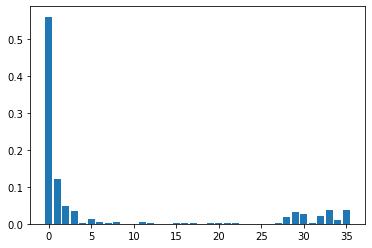

In [126]:
importance = rf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/randomForestCrossValidationImportance.pdf')

### Exploring difficult movies

35


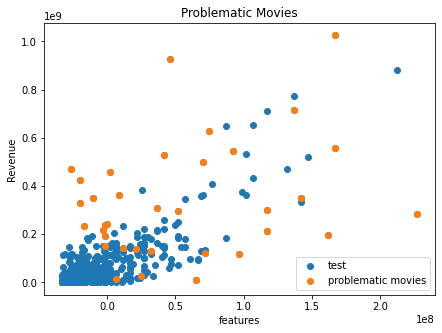

In [127]:
#error exploration
predicted_y = rf.predict(x_test)
sel_errors_pos = []
errors = np.square((predicted_y - y_test)**2)
test_acc = np.mean(errors)
for i, err in enumerate(errors):
    if(err > test_acc):
        sel_errors_pos.append((i))
        
#graphics with PCA
pca = PCA(n_components=1)
x = pca.fit_transform(x_test)
problematic_movies = x[sel_errors_pos]
print(len(y_test[sel_errors_pos]))
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x, y_test, label='test')
ax.scatter(problematic_movies, y_test[sel_errors_pos], label='problematic movies')
ax.set_title("Problematic Movies")
ax.set_xlabel("features")
ax.set_ylabel("Revenue")
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/problematicMovies.pdf')



In [ ]:
# graphics of the features for the difficult movies
for i in range(36):
    problematic = (x_test[sel_errors_pos][:,i])
    test = x_test[:,i]
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(test, y_test, label='test')
    ax.scatter(problematic, y_test[sel_errors_pos], label="Problematic movies")
    ax.set_title("Problematic Movies")
    ax.set_xlabel(dataset.columns[i])
    ax.set_ylabel("Revenue")
    ax.legend()

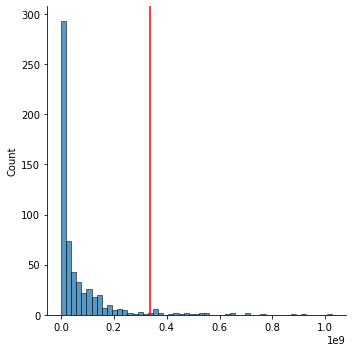

In [129]:
# average revenue for difficult movies
ax = sns.displot((y_test))
plt.axvline(np.mean((y_test[sel_errors_pos])), color='red')
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/problematicMoviesDisplot.pdf')

### AdaBoost

In [130]:
#boosting
x = dataset_mat[:,:36]
y = dataset_mat[:,36]
x_train_80, x_test, y_train_80, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
rf = RandomForestRegressor(n_estimators=int(best_k))
adaboost = AdaBoostRegressor(rf)
adaboost.fit(x_train_80,y_train_80)
adaboost.score(x_test,y_test)

0.6871003986262034

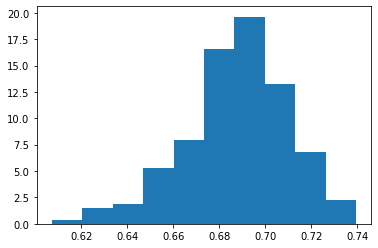

In [131]:
hist_data = []
for i in range (0,200):
    rf = RandomForestRegressor(n_estimators=int(best_k))
    adaboost = AdaBoostRegressor(rf)
    adaboost.fit(x_train_80,y_train_80)
    hist_data.append(adaboost.score(x_test,y_test))
plt.hist(hist_data, density = True)
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/adaBoostHist.pdf')

33


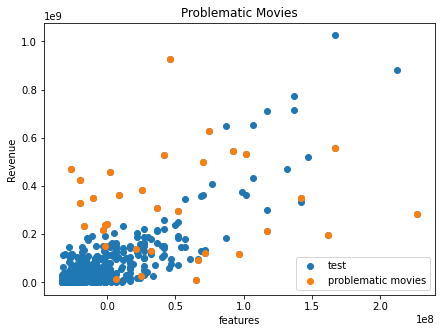

In [132]:
#graphics of difficult movies
predicted_y = adaboost.predict(x_test)
sel_errors_pos = []
errors = np.square((predicted_y - y_test)**2)
test_acc = np.mean(errors)
for i, err in enumerate(errors):
    if(err > test_acc):
        sel_errors_pos.append((i))

pca = PCA(n_components=1)
x = pca.fit_transform(x_test)
problematic_movies = x[sel_errors_pos]
print(len(y_test[sel_errors_pos]))
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x, y_test, label='test')
ax.scatter(problematic_movies, y_test[sel_errors_pos], label='problematic movies')
ax.set_title("Problematic Movies")
ax.set_xlabel("features")
ax.set_ylabel("Revenue")
ax.legend()
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/problematicMoviesBoost.pdf')



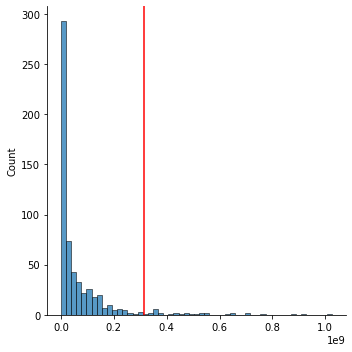

In [133]:
#grafici con revenue
ax = sns.displot((y_test))
plt.axvline(np.mean((y_test[sel_errors_pos])), color='red')
plt.savefig('C:/Users/bais_/OneDrive/Desktop/Università/Informatica/Data & Web Mining/Progetto/Grafici/problematicMoviesBoostDisplot.pdf')